In [95]:
!pip install seaborn==0.11.0

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


# Milestone 3: Predicting the Presidential and House of Representative Elections
#### Estelle Yao, Noah Ramos, Saul Holding, Ivan Shu

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from time import sleep

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 1500)

import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# EDA

In [97]:
# NOTE: We plan test our base model on three different predictors and for each party. All is made clear in the accompanying document
# Reading in the data
# data_train = pd.read_csv('train_test_data/train_updated2.csv')
# test_df = pd.read_csv('train_test_data/testing_set.csv')

data_train = pd.read_csv('train_test_data/train_updated3.csv')

# Changing data types to floats
data_train['Poverty Estimate, All Ages']=data_train['Poverty Estimate, All Ages'].astype(float)
data_train['Poverty Percent, All Ages']=data_train['Poverty Percent, All Ages'].astype(float)
data_train['Poverty Estimate, Age 0-17']=data_train['Poverty Estimate, Age 0-17'].astype(float)
data_train['Poverty Percent, Age 0-17']=data_train['Poverty Percent, Age 0-17'].astype(float)
data_train['Poverty Estimate, Age 5-17 in Families']=data_train['Poverty Estimate, Age 5-17 in Families'].astype(float)
data_train['Poverty Percent, Age 5-17 in Families']=data_train['Poverty Percent, Age 5-17 in Families'].astype(float)
data_train['Median Household Income']=data_train['Median Household Income'].astype(float)
data_train['Poverty Estimate, All Ages']=data_train['Poverty Estimate, All Ages'].astype(float)

###Added variables: lag response = percentage voted for democrats/republicans in 2012/percentage voted for democrats in 2008 
data_train['lag_response_dem']=data_train['Democrats 2012']/data_train['Democrats 2008']
data_train['lag_response_rep']=data_train['Republicans 2012']/data_train['Republicans 2008']

##Outcome variables: percentage of votes weighted by county population
data_train['response_rep']=data_train['TOT_POP']*data_train['Republicans 2016']
data_train['response_dem']=data_train['TOT_POP']*data_train['Democrats 2016']

# Adding in the different responses
data_train['log_response_dem'] = np.log(data_train['response_dem'])
data_train['log_response_rep'] = np.log(data_train['response_rep'])

# Converting number of advanced ballots to percentage
data_train['bal2016/popu2016'] = data_train['calculated approx. county adv. Ballots 2016'] / data_train['2016 Population']

# Recalculate 
data_train['perc_adv'] = data_train['calculated approx. county adv. Ballots 2016'] / data_train['2016 Population']

display(data_train.describe())
print(data_train.shape)

,Unnamed: 0,FIPS,Precincts,Votes,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),Republicans 2016,Democrats 2016,Green 2016,Libertarians 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,FIPS.1,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,"Poverty Estimate, All Ages","Poverty Percent, All Ages","Poverty Estimate, Age 0-17","Poverty Percent, Age 0-17","Poverty Estimate, Age 5-17 in Families","Poverty Percent, Age 5-17 in Families",Median Household Income,NIPR,NUI,NIC,PCTUI,PCTIC,PCTELIG,PCTLIIC,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,pres_rep_receipts,pres_rep_disburse,pres_rep_cash_on_hand,pres_dem_receipts,pres_dem_disburse,pres_dem_cash_on_hand,senate_rep_receipts,senate_rep_disburse,senate_rep_cash_on_hand,senate_dem_receipts,senate_dem_disburse,senate_dem_cash_on_hand,# of state advanced ballots cast 2012,# of state advanced ballots cast 2016,# votes 2012,# votes 2016,% of state pop 2012,% of state pop 2016,2012 Population,2016 Population,calculated approx. county adv. Ballots 2012,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,state population 2012,state population 2016,Democrats 12,Republicans 12,Democrats 08,Republicans 08,lag_response_dem,lag_response_rep,response_rep,response_dem,house_rep_receipts,house_rep_disburse,house_rep_cash_on_hand,house_dem_receipts,house_dem_disburse,house_dem_cash_on_hand,dem_poll_mean,rep_poll_mean,adj_dem_poll_mean,adj_rep_poll_mean,dem_poll_median,rep_poll_median,adj_dem_poll_median,adj_rep_poll_median,dem_poll_sd,rep_poll_sd,adj_dem_poll_sd,adj_rep_poll_sd,log_response_dem,log_response_rep,bal2016/popu2016,perc_adv
count,3139.000000,3139.000000,3111.000000,3.111000e+03,3.111000e+03,3.111000e+03,3111.000000,3111.000000,3111.000000,3111.000000,2601.000000,3111.000000,3111.000000,3111.000000,3111.000000,3111.000000,3139.0,3139.0,3139.0,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3139.000000,3.139000e+03,3.139000e+03,3139.000000,3139.0

(3139, 198)


In [98]:
####Divide demographic data by total population in the county so each variable would not correlate with population size
demo=data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1]=temp

demo=data_train.iloc[:, data_train.columns.get_loc('Civilian_labor_force_2016'):data_train.columns.get_loc('Unemployed_2016')+1]
temp=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('Civilian_labor_force_2016'):data_train.columns.get_loc('Unemployed_2016')+1]=temp

data_train.loc[:, 'Poverty Estimate, All Ages']=data_train.loc[:, 'Poverty Estimate, All Ages']/data_train['TOT_POP']*100

demo=data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1]
temo=pd.DataFrame()
for col in demo.columns:
    temp[col]=data_train[col]/data_train['TOT_POP']*100
data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1]=temp


In [99]:
business=data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]
b_tot=business.sum(axis=1)

temp=pd.DataFrame()
for col in business.columns:
    temp[col]=data_train[col]/b_tot*100

temp=temp.fillna(0) 

data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]=temp

In [100]:
data_train.head()

,Unnamed: 0,State,ST,FIPS,County,Precincts,Votes,Democrats 08 (Votes),Democrats 12 (Votes),Republicans 08 (Votes),Republicans 12 (Votes),Republicans 2016,Democrats 2016,Green 2016,Libertarians 2016,Republicans 2012,Republicans 2008,Democrats 2012,Democrats 2008,SUMLEV,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,WA_MALE,WA_FEMALE,BA_MALE,BA_FEMALE,IA_MALE,IA_FEMALE,AA_MALE,AA_FEMALE,NA_MALE,NA_FEMALE,TOM_MALE,TOM_FEMALE,WAC_MALE,WAC_FEMALE,BAC_MALE,BAC_FEMALE,IAC_MALE,IAC_FEMALE,AAC_MALE,AAC_FEMALE,NAC_MALE,NAC_FEMALE,NH_MALE,NH_FEMALE,NHWA_MALE,NHWA_FEMALE,NHBA_MALE,NHBA_FEMALE,NHIA_MALE,NHIA_FEMALE,NHAA_MALE,NHAA_FEMALE,NHNA_MALE,NHNA_FEMALE,NHTOM_MALE,NHTOM_FEMALE,NHWAC_MALE,NHWAC_FEMALE,NHBAC_MALE,NHBAC_FEMALE,NHIAC_MALE,NHIAC_FEMALE,NHAAC_MALE,NHAAC_FEMALE,NHNAC_MALE,NHNAC_FEMALE,H_MALE,H_FEMALE,HWA_MALE,HWA_FEMALE,HBA_MALE,HBA_FEMALE,HIA_MALE,HIA_FEMALE,HAA_MALE,HAA_FEMALE,HNA_MALE,HNA_FEMALE,HTOM_MALE,HTOM_FEMALE,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE,FIPS.1,At Least High School Diploma,At Least Bachelors's Degree,Graduate Degree,School Enrollment,Civilian_labor_force_2016,Employed_2016,Unemployed_2016,Unemployment_rate_2016,Postal Code,"Poverty Estimate, All Ages","Poverty Percent, All Ages","Poverty Estimate, Age 0-17","Poverty Percent, Age 0-17","Poverty Estimate, Age 5-17 in Families","Poverty Percent, Age 5-17 in Families",Median Household Income,NIPR,NUI,NIC,PCTUI,PCTIC,PCTELIG,PCTLIIC,--,Administrative,Agriculture,Construction,Educational Services,Finance,Food services,Health care,Information,Management,Manufacturing,Mining,Other,Professional Services,Real Estate,Recreation,Retail,Transportation,Utitilities,Wholesale,pres_rep_receipts,pres_rep_disburse,pres_rep_cash_on_hand,pres_dem_receipts,pres_dem_disburse,pres_dem_cash_on_hand,senate_rep_receipts,senate_rep_disburse,senate_rep_cash_on_hand,senate_dem_receipts,senate_dem_disburse,senate_dem_cash_on_hand,# of state advanced ballots cast 2012,# of state advanced ballots cast 2016,# votes 2012,# votes 2016,% of state pop 2012,% of state pop 2016,2012 Population,2016 Population,calculated approx. county adv. Ballots 2012,calculated approx. county adv. Ballots 2016,early_voting,felony_laws,id_laws,reg_laws,state population 2012,state population 2016,Democrats 12,Republicans 12,Democrats 08,Republicans 08,lag_response_dem,lag_response_rep,response_rep,response_dem,house_rep_receipts,house_rep_disburse,house_rep_cash_on_hand,house_dem_receipts,house_dem_disburse,house_dem_cash_on_hand,state,dem_poll_mean,rep_poll_mean,adj_dem_poll_mean,adj_rep_poll_mean,dem_poll_median,rep_poll_median,adj_dem_poll_median,adj_rep_poll_median,dem_poll_sd,rep_poll_sd,adj_dem_poll_sd,adj_rep_poll_sd,log_response_dem,log_response_rep,bal2016/popu2016,perc_adv
0,0,Alabama,AL,1005,Barbour County,18.0,10390.0,5697.0,5912.0,5866.0,5550.0,52.271415,46.660250,0.173244,0.895091,48.189633,50.438521,51.332812,48.985383,50,9,0,25806,52.801674,47.198326,26.269085,23.525537,25.246067,22.700147,0.352631,0.232504,0.209254,0.224754,0.108502,0.050376,159,120,6897,6176,6622,5929,168,107,69,78,33,18,13004,11689,6272,5665,6473,5811,40,33,54,58,16,6,149,116,6383,5766,6573,5881,111,78,69,77,21,11,622,491,507,406,42,47,51,27,0,0,12,7,10,4,514,410,49,48,57,29,0,1,12,7,1005,71.9,13.5,6.0,67.85,32.690072,29.977525,2.712547,8.3,AL,26.300085,29.9,2146.0,39.6,1502.0,36.8,32884.0,17997.0,8.726653,61.012943,12.5,87.5,12.5,87.5,16.666667,1.106195,2.396755,4.240413,0.921829,7.743363,9.402655,7.927729,0.921829,0.000000,4.977876,0.737463,6.637168,5.899705,3.687316,0.921829,16.224189,5.346608,1.474926,2.765487,205.0,5271.0,0.0,0.0,0.0,0.0,5914160.0,13077935.0,9992806.0,33268.0,32369.0,442.0,0,2399,11509.0,10469.0,0.005642,0.005306,27169,25806,0.0,12.729161,2.0,1.0,3.0,2.0,4815588,4863525,51.579131,48.420869,49.269221,50.730779,1.047921,0.955413,1.348916e+06,1.204114e+06,7539913.77,6867367.47,3303589.32,1935424.42,1389839.56,964586.58,Alabama,31.619535,54.308

## EDA on Response Variables

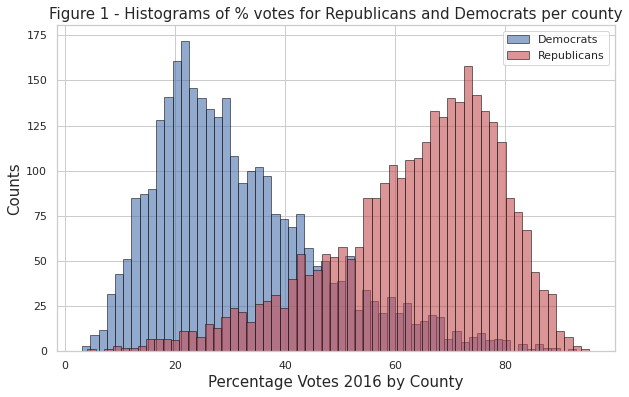

In [101]:
# Intializing plot
plt.figure(figsize=(10,6))

# Plotting histograms 
plt.hist(data_train['Democrats 2016'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['Republicans 2016'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Percentage Votes 2016 by County', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 1 - Histograms of % votes for Republicans and Democrats per county', fontsize=15)

# Setting legend
plt.legend()

plt.show()

Figure 1 - Histograms of % votes for Republicans and Democrats per county

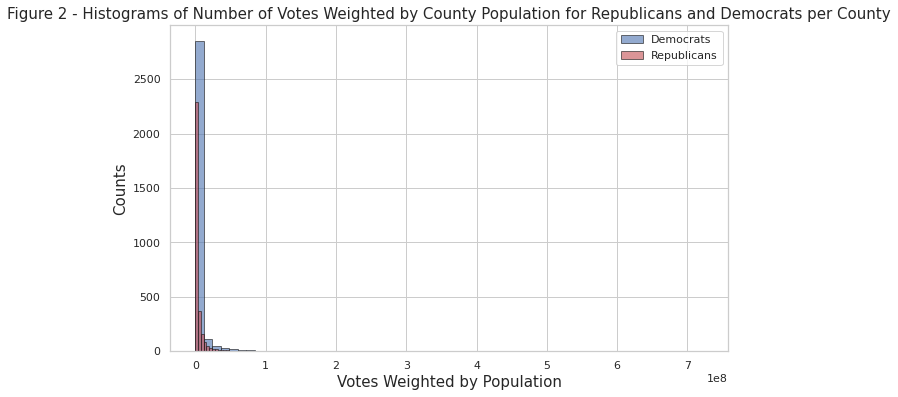

In [102]:
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train['response_dem'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['response_rep'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Votes Weighted by Population', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 2 - Histograms of Number of Votes Weighted by County Population for Republicans and Democrats per County', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 2 - Histograms of Number of Votes Weighted by County Population for Republicans and Democrats per County

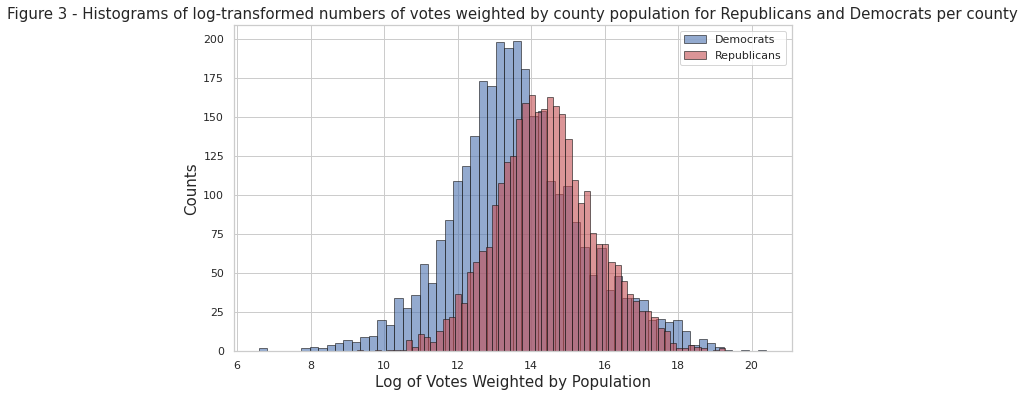

In [103]:
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train['log_response_dem'], bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train['log_response_rep'], bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Log of Votes Weighted by Population', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 3 - Histograms of log-transformed numbers of votes weighted by county population for Republicans and Democrats per county', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 3 - Histograms of log-transformed numbers of votes weighted by county population for Republicans and Democrats per county

## Voting Consistency

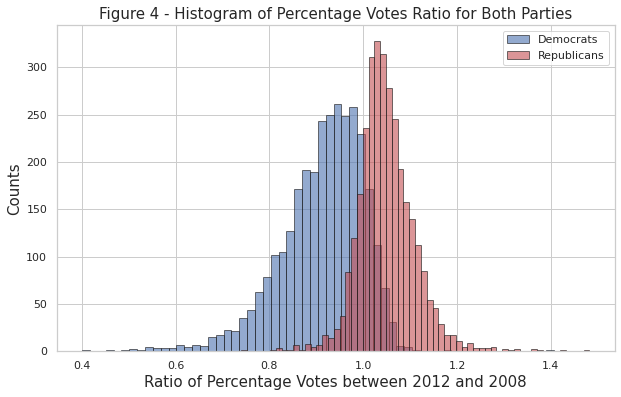

In [104]:
# Now, we are dealing with both 'lag_response_dem' and 'lag_response_rep' variables.
# Figure 3 - Histogram of Percentage Votes Ratio between 2012 and 2008 for Both Parties
# Initialzing plot
plt.figure(figsize=(10,6))

# Plotting histogram
plt.hist(data_train.lag_response_dem, bins=60, edgecolor='k', alpha=0.6, 
        color='b', label='Democrats')
plt.hist(data_train.lag_response_rep, bins=60, edgecolor='k', alpha=0.6, 
         color='r', label='Republicans')

# Setting labels
plt.xlabel('Ratio of Percentage Votes between 2012 and 2008', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Figure 4 - Histogram of Percentage Votes Ratio for Both Parties', fontsize=15)

# Setting legend
plt.legend()
plt.show()

Figure 4 - Histogram of Percentage Votes Ratio for Both Parties

In [105]:
# This suggests that majorities of counties are shifting their voting habits 
# And they are moving to vote more for republicans
# in 2016. This makes sense as Trump won the election.

## EDA on Demographic and Business Data

In [106]:
# I will use train_merge.columns a bit later
# to get the column names of this
demographic_business=pd.concat([data_train.iloc[:, data_train.columns.get_loc('TOT_MALE'):data_train.columns.get_loc('NA_FEMALE')+1],
                       data_train.iloc[:, data_train.columns.get_loc('At Least High School Diploma'):data_train.columns.get_loc('School Enrollment')+1],
                       data_train.loc[:, 'Poverty Estimate, All Ages'],
                       data_train.loc[:, 'Median Household Income'],
                       data_train.iloc[:, data_train.columns.get_loc('NUI'):data_train.columns.get_loc('NIC')+1],
                       data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]], axis=1).drop('School Enrollment', axis = 1)

In [107]:
# Shape
print(f"The shape is: {demographic_business.shape}")

The shape is: (3139, 39)


In [108]:
# Defining correlation variable
demographic_business_cor=demographic_business.corr(method="pearson")

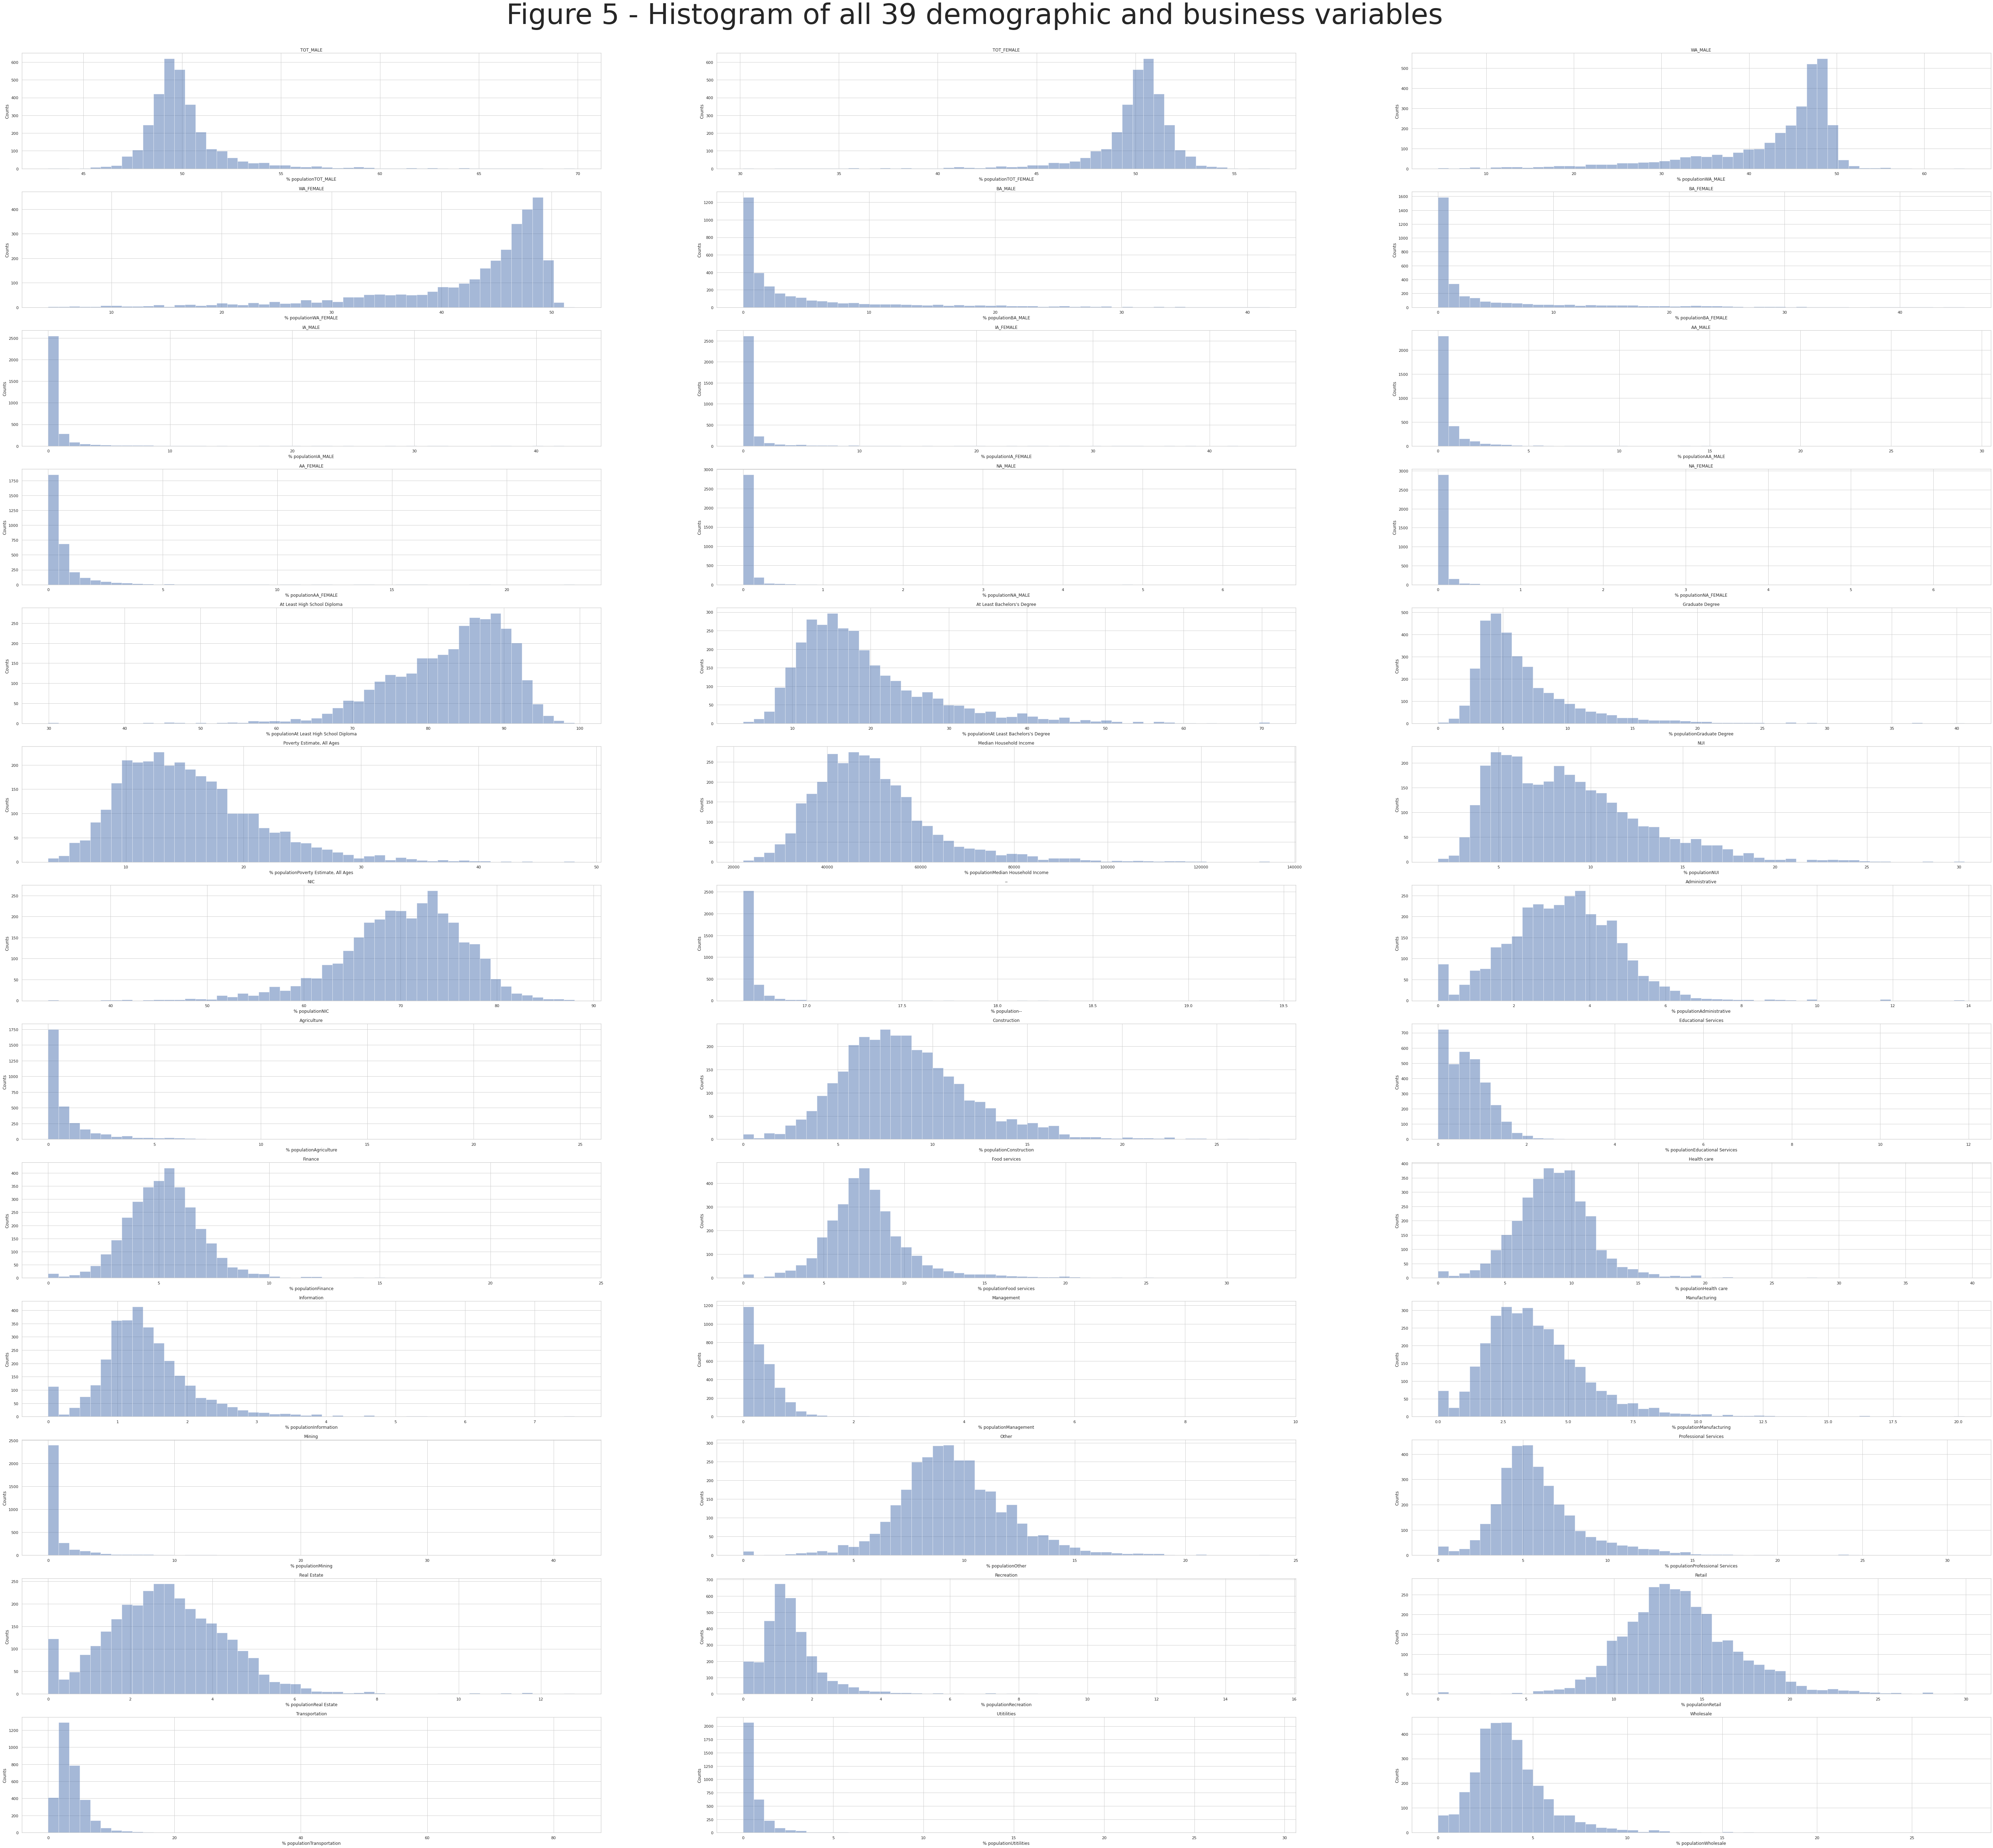

In [109]:
# Plotting percentage of votes against Business predictors and Demographic data
plt.figure(figsize=[100,100])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.hist(x=( (demographic_business[col])), bins=50, alpha=0.5)
    plt.ylabel('Counts')
    plt.xlabel('% population' + col)
    plt.title(col)

plt.suptitle("Figure 5 - Histogram of all 39 demographic and business variables", y = .90, fontsize=80)
plt.show()

Figure 5 - Histogram of all 40 demographic and business variables

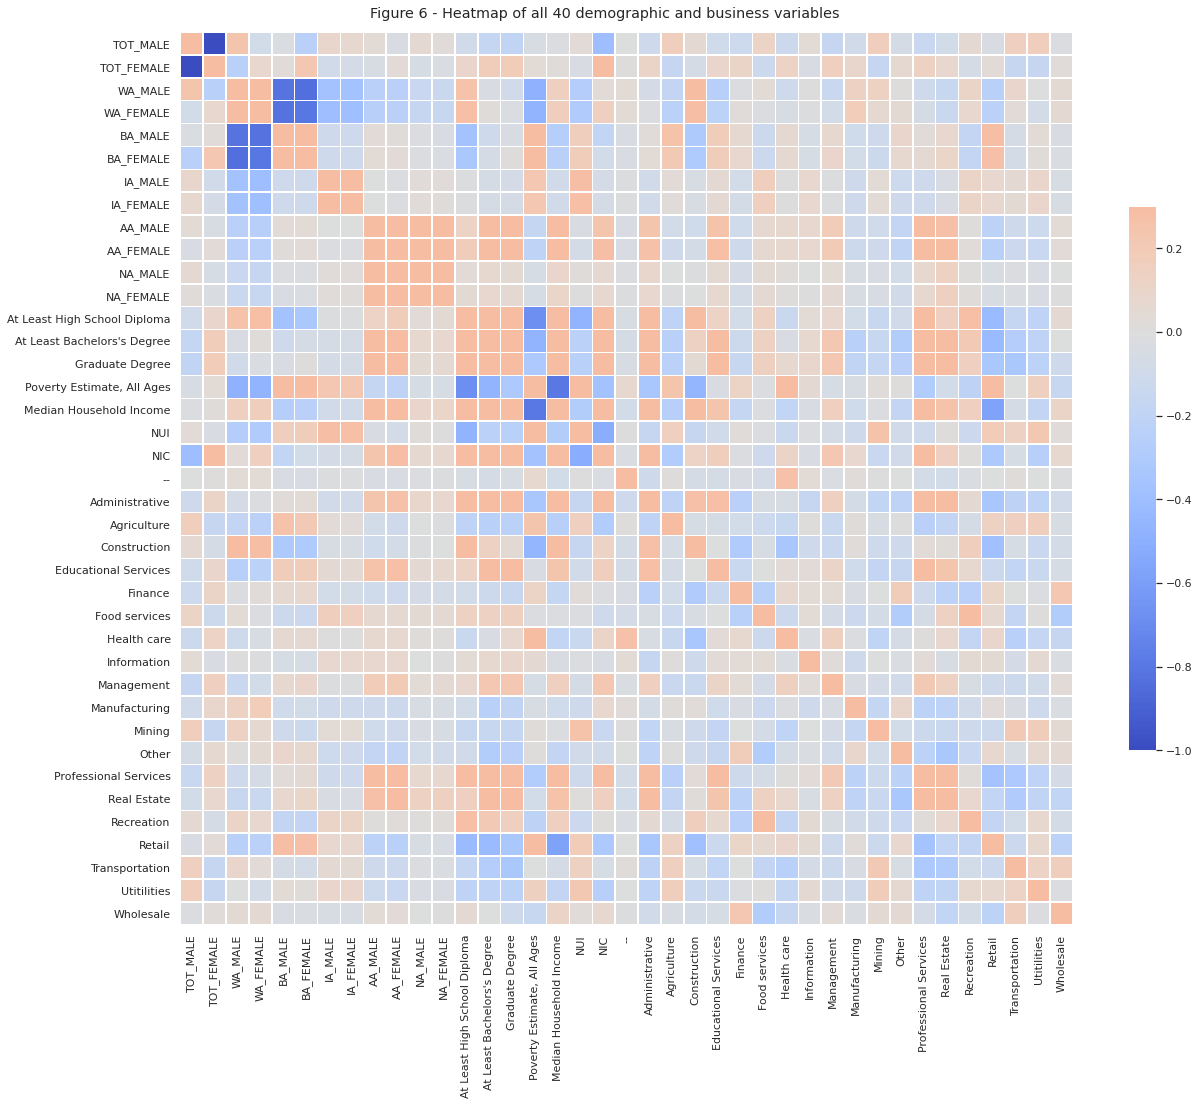

In [110]:
# Plotting a correlation heat map with demographic data dand business data
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(demographic_business_cor, cmap="coolwarm",vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.suptitle("Figure 6 - Heatmap of all 40 demographic and business variables", x=.42, y=.83)
plt.show()

There is not much correlation among variables thus less concern for problems of collinearity  

Figure 6 - Heatmap of all 41 demographic and business variables

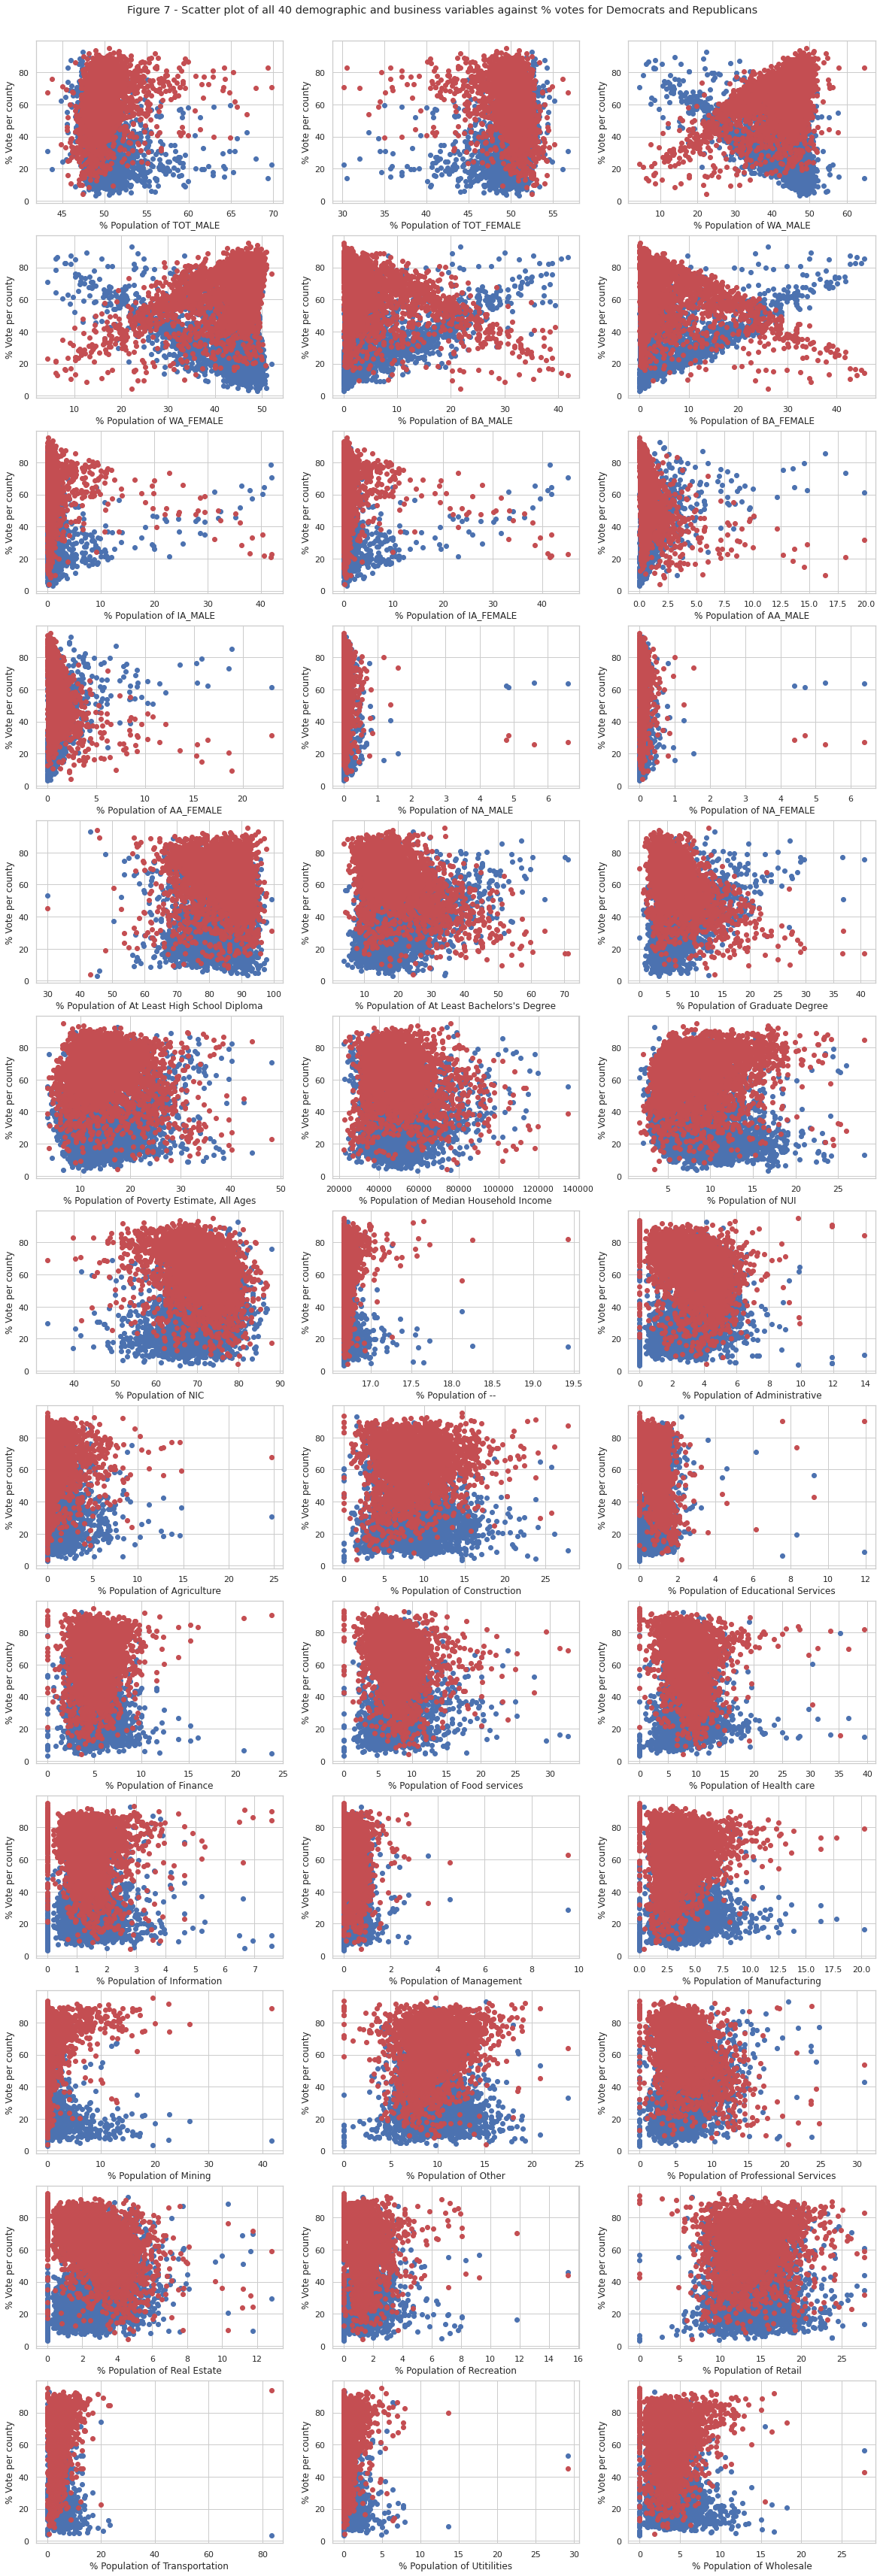

In [111]:
###Regression to election outcome 2016 
plt.figure(figsize=[20,66])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=data_train['Democrats 2016'], x=(demographic_business[col]) ,color='b')
    plt.scatter(y=data_train['Republicans 2016'], x=(demographic_business[col]),color='r' )
    plt.xlabel('% Population of ' + col)
    plt.ylabel('% Vote per county')

plt.suptitle("Figure 7 - Scatter plot of all 40 demographic and business variables against % votes for Democrats and Republicans", y = .89)
plt.show()

Figure 7 - Scatter plot of all 41 demographic and business variables against % votes for Democrats and Republicans

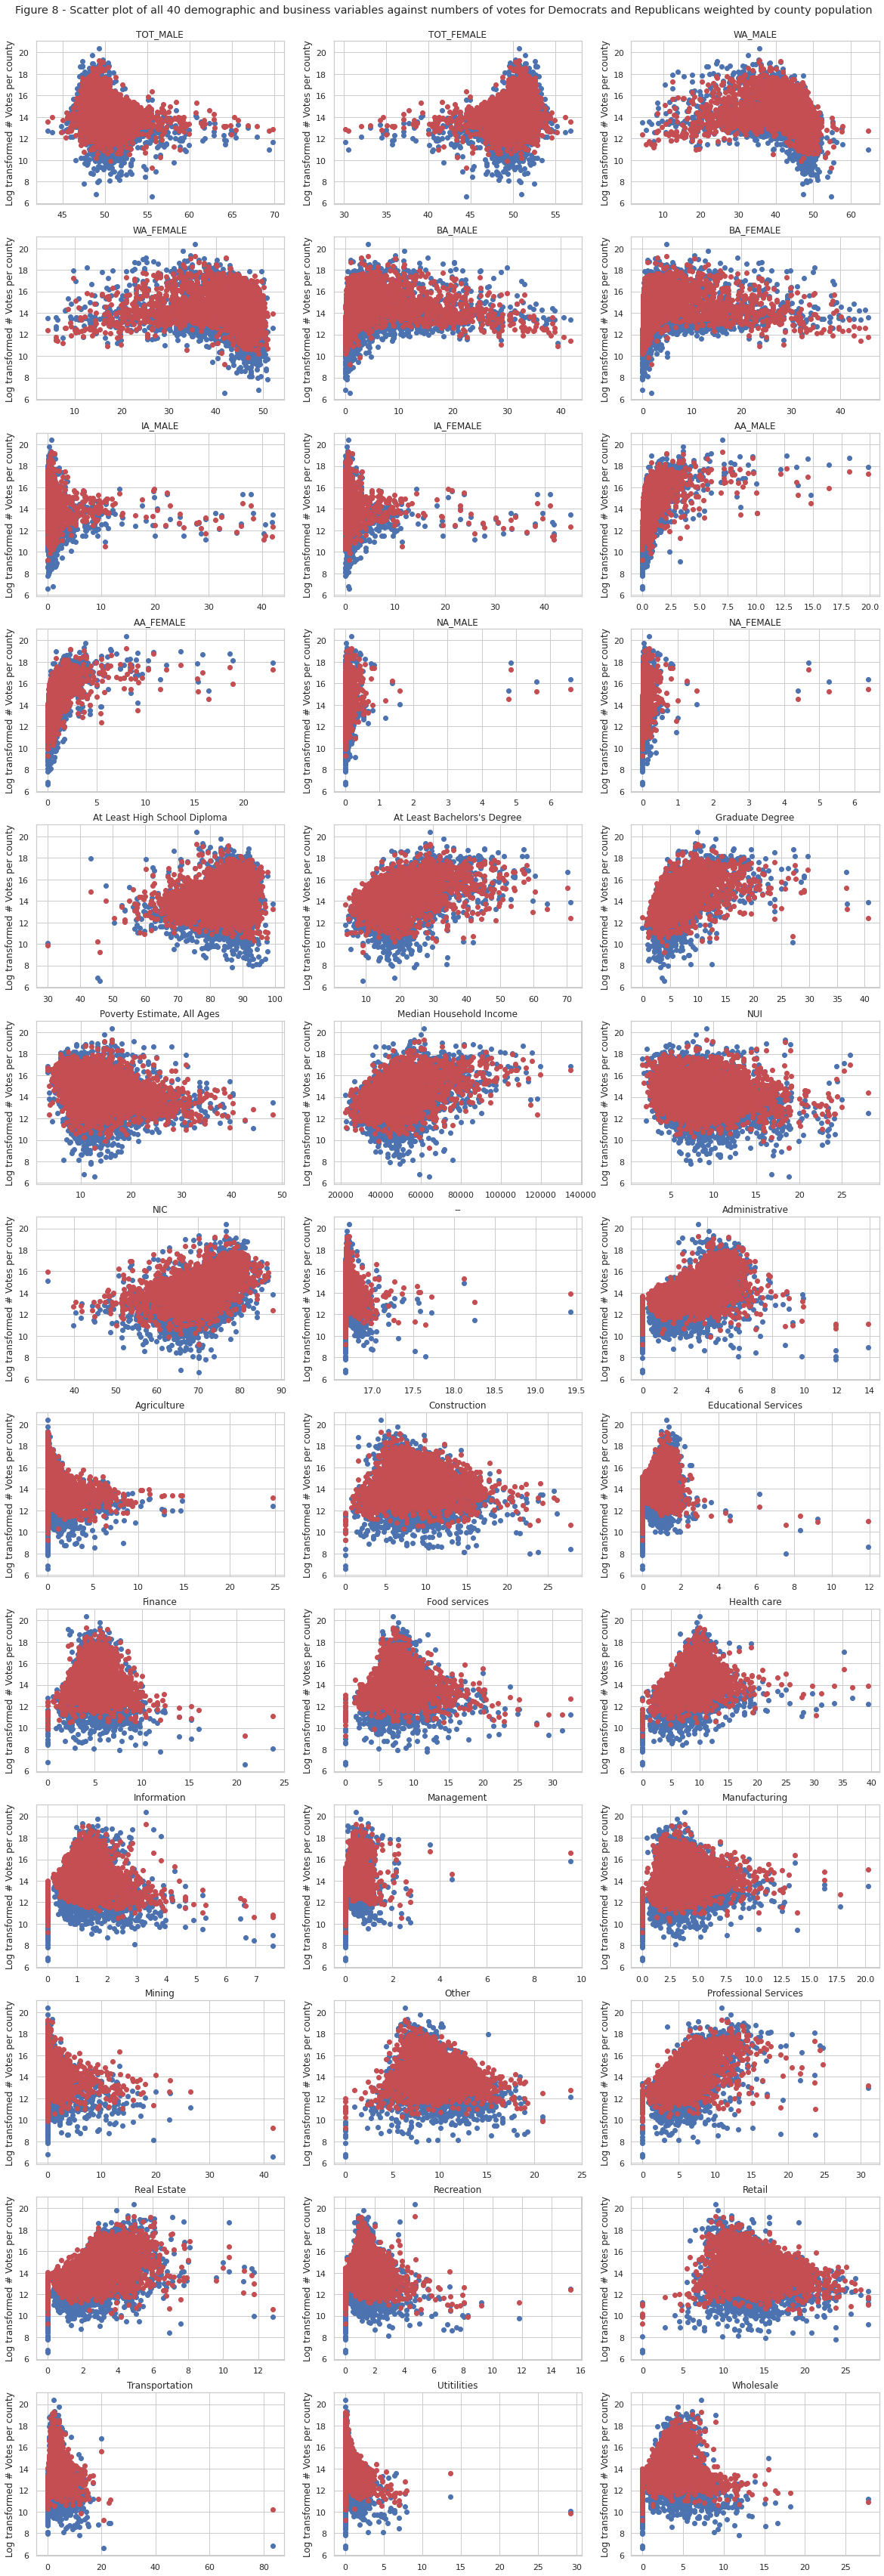

In [112]:
###correlation with # votes 

plt.figure(figsize=[20,66])

for i, col in enumerate(demographic_business.columns):
    plt.subplot(14, 3, i+1)
    plt.scatter(y=np.log(data_train['response_dem']), x=(demographic_business[col]) ,color='b')
    plt.scatter(y=np.log(data_train['response_rep']), x=(demographic_business[col]),color='r' )
    plt.ylabel('Log transformed # Votes per county')
    plt.title(col)

plt.suptitle("Figure 8 - Scatter plot of all 40 demographic and business variables against numbers of votes for Democrats and Republicans weighted by county population", y=.89)

plt.show()

Figure 8 - Scatter plot of all 41 demographic and business variables against numbers of votes for Democrats and Republicans weighted by county population

## EDA on House of Representatives Financial Data

In [113]:
 ## Note: We will analyze these variable on all three response variable we plan to use

In [114]:
# Finance
finance=data_train.iloc[:, data_train.columns.get_loc('house_rep_receipts'):data_train.columns.get_loc('house_dem_cash_on_hand')+1]
finance.shape


(3139, 6)

In [115]:
# Describing the data
finance.describe()

,house_rep_receipts,house_rep_disburse,house_rep_cash_on_hand,house_dem_receipts,house_dem_disburse,house_dem_cash_on_hand
count,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03,3.139000e+03
mean,1.576236e+07,1.493184e+07,4.196804e+06,9.709655e+06,8.698864e+06,2.700840e+06
std,1.352539e+07,1.308636e+07,4.149659e+06,1.414240e+07,1.268135e+07,4.299082e+06
min,0.000000e+00,0.000000e+00,-3.896720e+03,3.766634e+04,2.882283e+04,0.000000e+00
25%,6.117663e+06,6.041473e+06,1.070736e+06,1.438342e+06,1.248608e+06,3.838517e+05
50%,1.384217e+07,1.295522e+07,2.794079e+06,4.405427e+06,3.979693e+06,9.883107e+05
75%,1.961964e+07,1.822542e+07,5.245551e+06,1.379829e+07,1.018831e+07,3.211977e+06
max,4.726561e+07,4.822634e+07,1.391429e+07,8.116243e+07,7.071228e+07,2.616824e+07


In [116]:
# Dipslaying the info
finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3139 entries, 0 to 3138
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   house_rep_receipts      3139 non-null   float64
 1   house_rep_disburse      3139 non-null   float64
 2   house_rep_cash_on_hand  3139 non-null   float64
 3   house_dem_receipts      3139 non-null   float64
 4   house_dem_disburse      3139 non-null   float64
 5   house_dem_cash_on_hand  3139 non-null   float64
dtypes: float64(6)
memory usage: 147.3 KB


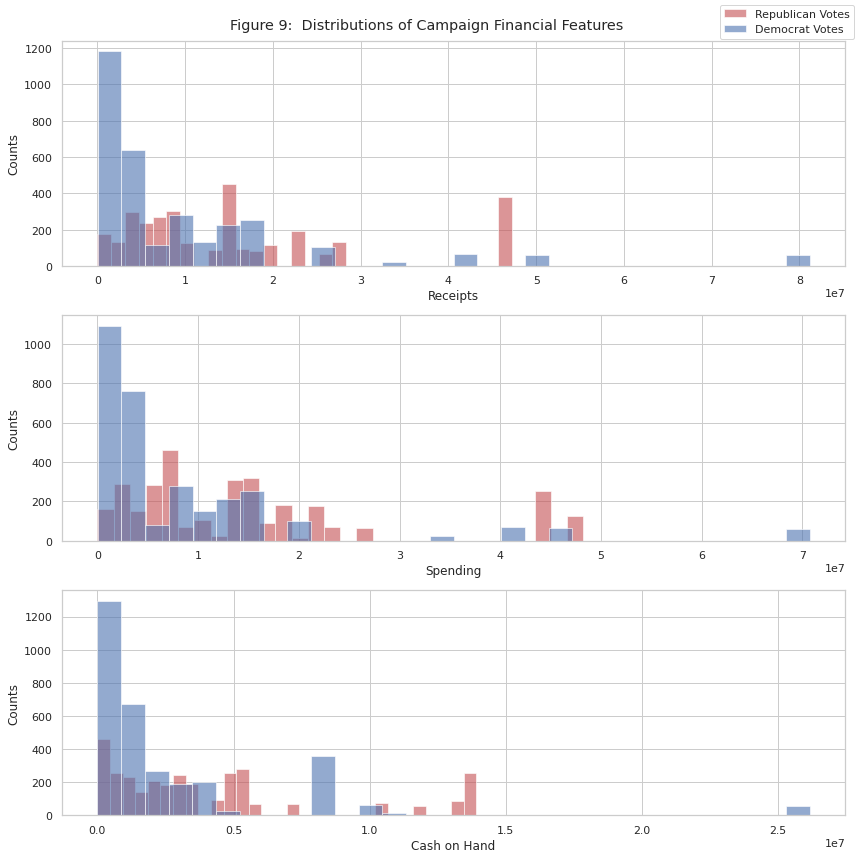

In [117]:
# Setting lists
dem_finance = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand']
rep_finance = ['house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
names_finance = ['Receipts', "Spending", 'Cash on Hand']

# Initializing the subplots
fig, ax  = plt.subplots(nrows= 3, figsize=(12,12))

# Setting counters
r = 0

# Plotting
for rep, dem, n in zip(rep_finance, dem_finance, names_finance):
    if rep == 'house_rep_receipts' and dem == 'house_dem_receipts':
        ax[r].hist(data_train[rep], bins = 30, color = 'r', alpha = .6, label = 'Republican Votes')
        ax[r].hist(data_train[dem], bins = 30, color = 'b', alpha = .6, label = 'Democrat Votes')
        ax[r].set_xlabel(n)
        ax[r].set_ylabel('Counts')
        r+=1
    else:
        ax[r].hist(data_train[rep], bins = 30, color = 'r', alpha = .6)
        ax[r].hist(data_train[dem], bins = 30, color = 'b', alpha = .6)
        ax[r].set_xlabel(n)
        ax[r].set_ylabel('Counts')
        r+=1

# Setting legend
fig.legend(loc='upper right')

# Setting the super title
fig.suptitle("Figure 9:  Distributions of Campaign Financial Features")

# Making the layout tighter
fig.tight_layout()

plt.show()


Figure 9:  Distributions of Campaign Financial Features

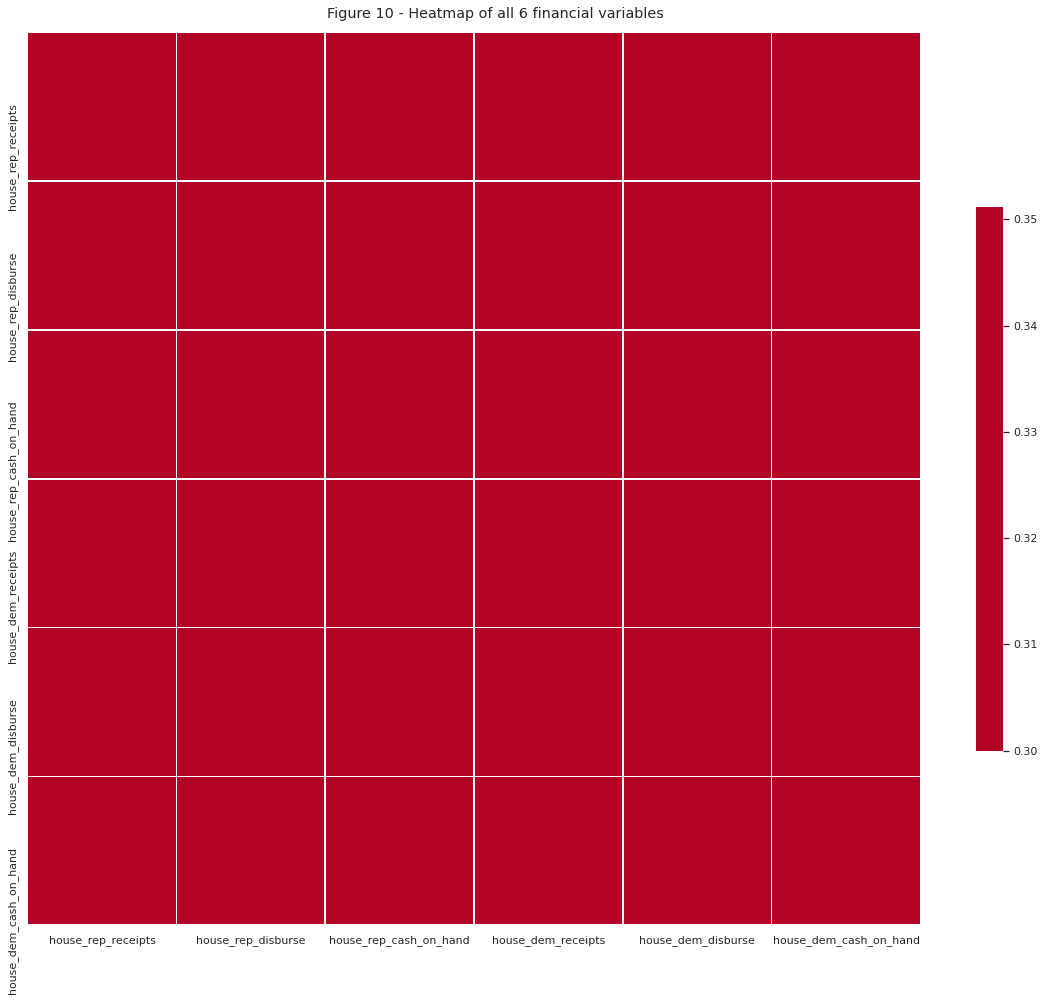

In [118]:
# Correlation variable
train_finance_cor=finance.corr(method="pearson")

# Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(train_finance_cor, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.suptitle("Figure 10 - Heatmap of all 6 financial variables", x=.45, y=.83)
plt.show()

Figure 10 - Heatmap of all 6 financial variables

In [119]:
# Setting lists needed for the plotting
finance_list = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
y_dem = ['Democrats 2016', 'log_response_dem', 'response_dem']
y_rep = ['Republicans 2016', 'log_response_rep', 'response_rep']
names_response = ['Percentage Votes', 'Logged Votes', 'Votes']


# Intializing the subplots
fig, ax  = plt.subplots(nrows= 6, ncols=3, figsize=(20,20))

# Setting counters
r = 0
c = 0 

# Looping through the finanical data, response variables, and names to create the graphs
for fin in finance_list:
    for a,b,n2 in zip(y_rep, y_dem, names_response):
    
        if fin == "house_rep_receipts" and a == "Republicans 2016":

            ax[r,c].scatter(y=data_train[b], x=finance[fin], color='b' , label = "Democrat Votes")
            ax[r,c].scatter(y=data_train[a], x=finance[fin], color='r', label = 'Republican Votes')
            ax[r,c].set_ylabel(n2)
            ax[r,c].set_xlabel(fin)

            

        else:
            ax[r,c].scatter(y=data_train[b], x=finance[fin], color='b' , alpha = .6)
            ax[r,c].scatter(y=data_train[a], x=finance[fin], color='r', alpha = .6)
            
            ax[r,c].set_ylabel(n2)
            ax[r,c].set_xlabel(fin)

        if c < 2:
            c += 1
        else:
            r+=1
            c=0
# Fitting legend
fig.legend(loc='upper right')

# Setting the super title
fig.suptitle("Figure 11 - Scatter Plot of all Financial Features and Different Response Variables")

# Making the layout tighter
fig.tight_layout()

plt.show()

KeyboardInterrupt: 

Figure 11 - Scatter Plot of all Financial Features and Different Response Variables

## EDA on Economic Data

In [27]:
## Ivan's EDA about Unemployment Rate:
## Here I am gonig to subset certian features
economic_df = data_train[['State', 'FIPS', 'County', 'Civilian_labor_force_2016', 'Employed_2016', 'Unemployed_2016', \
                    'Unemployment_rate_2016', 'lag_response_dem', 'lag_response_rep', \
                    'Democrats 2016', 'Republicans 2016']]

# mae a copy to get rid of the warning:
economic_df = economic_df.copy()

In [28]:
# Printing head
economic_df.head()

In [29]:
# Describing Economic Data
economic_df.describe()

In [30]:
# Getting Info
economic_df.info()

In [31]:
# Check rows that have null values
has_null = economic_df.isnull()
row_null = has_null.any(axis=1)

economic_null_row = economic_df[row_null]
economic_null_row.head()

## Found that there are many Alaska are missing republican's and demorates 2016 data
## So we are going to drop them for now.

In [32]:
economic_updated_df = economic_df.dropna()
economic_updated_df_c = economic_updated_df.copy()

In [33]:
economic_updated_df_c.info()

In [34]:
# First we are dealing with unemployment rate varaible
# make histogram for 'unemployment_rate_2016'
plt.figure(figsize=(10, 6))
plt.hist(economic_updated_df_c.Unemployment_rate_2016, bins=range(26), edgecolor='k', alpha=0.6,
        label='Unemployment Rate 2016')
# plt.hist(test_df.Unemployed_2019, bins=range(26), edgecolor='k', alpha=0.6, 
#          label= 'Unemployment Rate 2019-2020')

plt.ylabel('Count', fontsize=15)
plt.xlabel('Unemployment Rate(%)', fontsize=15)

plt.xticks(np.arange(25))
plt.title('Figure 12 - Histogram of Unemployment Rate (%) in 2016', fontsize=20)

plt.legend()
plt.show()

Figure 12 - Histogram of Unemployment Rate (%) in 2016 and 2019-2020)

In [35]:
# Figure 11 Histogram of Unemployment Rate (%) in 2016 and 2019-2020

# It seems the median and the mode of unemployment rate are falling 
# around 4-6 percent
# When comparing between Unemployment Rate 2019-2020, first of all, they are way less people reporting.
# Second, they unemployment rate are much higher in 2019-2020

In [36]:
# make scatter plot of unemployment rate vs resposne_dem and response_rep
plt.figure(figsize=(10, 6))

plt.scatter(economic_updated_df_c.Unemployment_rate_2016, economic_updated_df_c['Democrats 2016'], color='b', 
            alpha=0.5, label="%Votes for Democratics")
plt.scatter(economic_updated_df_c.Unemployment_rate_2016, economic_updated_df_c['Republicans 2016'], color='r',
            alpha=0.5, label='%Votes for Republicans')

plt.xlabel('2016 Unemployment Rate(%)', fontsize=15)
plt.ylabel(r'%Votes', fontsize=15)
plt.title('Figure 13 - Scatter Plot of Unemployment Rate (%) vs %Votes', fontsize=20)

plt.legend()

plt.show()

Figure 13 - Scatter Plot of Unemployment Rate (%) vs %Votes

## EDA on Voter Accessibility

In [37]:
laws = ['early_voting', 'felony_laws', 'id_laws', 'reg_laws']
xlabels = ['Early Voting Laws', 'Felony Laws', 'Identification Laws', 'Voter Regulation Laws']

responses = ['response_rep', 'log_response_rep', 'Republicans 2016']
ylabels = ['Est. Republican Vote', 'Log Est. Republican Vote', 'Percentage Republican Vote']

fig, axes = plt.subplots(3, 4, figsize = (20, 15))
for i in range(3):
    for j in range(4):
        sns.violinplot(ax = axes[i, j], x = data_train[laws[j]], y = data_train[responses[i]])
        axes[i, j].set_xlabel(xlabels[j])
        axes[i, j].set_ylabel(ylabels[i])
        axes[i, j].set_title(xlabels[j] + ' vs ' + ylabels[i])
        
        
plt.suptitle('Figure 14 - Violin Plots of Voter Distribution of Each Level of Law Strictness', fontsize = 20)
plt.tight_layout()
plt.show()

Figure 14 - Violin Plots of Voter Distribution of Each Level of Law Strictness

In [38]:
# violin plots of early voting law data
# plot against republican vote count, logged republic vote count, and percentage of republican votes by county
plt.hist(data_train['perc_adv'])
plt.title('Figure 15 - Histogram of County Advanced Voting Frequencies in 2016')
plt.xlabel('Percentage of County Advanced Votes')
plt.ylabel('Frequency')
plt.show()

Figure 15 - Histogram of County Advanced Voting Frequencies in 2016

### A Brief look at the Correlation Between All Features

In [39]:
# Subsetting for the relevant features
voting = data_train[laws]
economics = economic_df.drop(['State', 'FIPS', 'County', 'lag_response_dem', 'lag_response_rep', 'Democrats 2016', 'Republicans 2016'], axis = 1)

In [40]:
# Merging the features 
full_feature_df = pd.concat([demographic_business, economics, voting, finance],axis=1)

# Calculating correlation
full_merge_cor=full_feature_df.corr(method="pearson")

###Heatmap for chosen variables
f, ax = plt.subplots(figsize=(20, 20))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(full_merge_cor, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.suptitle("Figure 16 - Heatmap of All Features", x = .45, y = .83)
plt.show()

Figure 16 - Heatmap of All Features

### Importing and Cleaning the Test Data 

In [41]:
data_test = pd.read_csv('train_test_data/testing_housing_presidential.csv')
finance_2020 = pd.read_csv('train_test_data/house_financial_2020.csv')
polls_2020 = pd.read_csv('train_test_data/clean_polls_2020.csv')

data_test['State'] = data_test['STNAME']
data_test['At Least Bachelors\'s Degree'] = data_test['Percent of adults with a bachelor\'s degree or higher, 2014-18'] 
data_test['At Least High School Diploma'] = data_test['Percent of adults with a bachelor\'s degree or higher, 2014-18'] + data_test['Percent of adults with a high school diploma only, 2014-18'] + data_test['Percent of adults completing some college or associate\'s degree, 2014-18']
data_test['Poverty Estimate, All Ages'] = data_test.PCTPOVALL_2018.astype(float)
data_test['Median Household Income'] = data_test['MEDHHINC_2018']
data_test['Unemployment_rate'] = data_test['Unemployment_rate_2019']

finance_2020['State'] = finance_2020['state']
finance_2020 = finance_2020.drop('state', axis = 1)
data_test = data_test.merge(finance_2020, on = 'State')

data_test['bal/popu'] = data_test['calculated approx. county adv. Ballots 2020'] / data_test['TOT_POP']
data_test['lag_response_dem']=data_train['Democrats 2016']/data_train['Democrats 2012']

polls_2020['State'] = polls_2020['state']
polls_2020 = polls_2020.drop('state', axis = 1)
data_test = data_test.merge(polls_2020, on = 'State')



In [82]:
train_pred

# Baseline Model Analyses 
## Analysis on 2016 Presidential Election 
### Using Democratic Votes as the Base for the Response Variables

In [42]:
# Added response variable 
data_train['response'] = data_train['Democrats 2016'] / data_train['Republicans 2016']

In [43]:
for i in data_train:
    print(i)

In [44]:
## Building our model
# Initialie our predictor sets and I am training with response variables 'response_dem'
state = ['State']
demograph_pred = list(demographic_business.columns)
economic_pred = ['Unemployment_rate_2016']
financial_pred = ['house_dem_receipts', 'house_dem_disburse', 'house_dem_cash_on_hand', 'house_rep_receipts', 'house_rep_disburse', 'house_rep_cash_on_hand']
voting_pred = ['bal2016/popu2016', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']
consistency_pred = ['lag_response_dem']
response = ['response']
polls = ['dem_poll_mean', 'rep_poll_mean', 'dem_poll_median', 'rep_poll_median', 'dem_poll_sd', 'rep_poll_sd']

# all response variables

# all predictors
train_pred = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred + polls

# all predictors + response variables
train_pred_response = state + train_pred + response


In [45]:
#train_pred in list(train_df.columns)
for pred in train_pred:
    if pred not in list(data_train.columns):
        print(pred)

# This confirms that all predictors in our selected are in the training set.

In [46]:
# Here, i'm checking if there are any null values
# So, first, I need to replace all the missing values
# of business patterns with 0

business_nan = data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1]
business_nan_fill = business_nan.fillna(0)
data_train.iloc[:, data_train.columns.get_loc('--'):data_train.columns.get_loc('Wholesale')+1] = business_nan_fill


In [47]:
# All the nan has been filled
business_nan_fill[business_nan_fill.isnull().any(axis=1)]

In [48]:
# Now I'm checking the whole train_df
has_null = data_train[train_pred_response].isnull()
null_boolean = has_null.any(axis=1)

null_rows = data_train[train_pred_response][null_boolean]
null_rows.head()

In [49]:
## Same again, a lot of them are from Alaska, so we are 
## going to drop them for now. 
train_df_final = data_train[train_pred_response].dropna()
train_df_final = train_df_final.drop('State', axis = 1)
train_df_final.head()

In [51]:
# Dropping School Enrollment and Removing the 2016 identifier so the train dataset is identical to the test dataset
train_df_final = train_df_final.rename(columns={'Unemployment_rate_2016': 'Unemployment_rate', 'bal2016/popu2016': 'bal/popu'})

In [52]:
train_df_final.columns

In [53]:
## First, standardize all the training data
## The scaler can be used for future testing data
scaler = StandardScaler().fit(train_df_final)
train_df_final_s = scaler.transform(train_df_final)
train_df_final_s = pd.DataFrame(train_df_final_s, columns=train_df_final.columns)

In [54]:
# Describing data
train_df_final_s.describe()

In [55]:
# Initialize our X train and y train

economic_pred = ['Unemployment_rate']
voting_pred = ['bal/popu', 'early_voting', 'felony_laws', 'id_laws', 'reg_laws']

# all predictors
train_pred = demograph_pred + economic_pred + financial_pred + voting_pred + consistency_pred + polls

# all predictors + response variables
train_pred_response = state + train_pred + response

Xtrain = train_df_final_s[train_pred].values

ytrain = train_df_final_s['response'].values

# Get both shapes for both X and y
print(Xtrain.shape)
print(ytrain.shape)

#### Decision Tree Base Model (Democrat Votes)

In [56]:
compare_dict = {}

depths = list(range(1, 50))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    
    for depth in depths:
        dtree = DecisionTreeRegressor(max_depth=depth).fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        
        # append train score
        train_scores.append(train_score)
        
        # start cv
        cv = cross_val_score(estimator=dtree, X=X_train, y=y_train, 
                            scoring='r2', cv=5)
        
        # append to the means and stds
        cvmeans.append(cv.mean())
        cvstds.append(cv.std())
    
    # transform into np arrays
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores

cvmeans, cvstds, train_score = calc_meanstd(Xtrain, ytrain, depths)
    


In [57]:
## make the plot
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(depths, train_score, '.-', label='Training Score', lw=3)
ax.plot(depths, cvmeans, '.-', label='CV Score', lw=3)
plt.fill_between(depths, cvmeans+2*cvstds, cvmeans-2*cvstds, color='#F5F3BB', 
                alpha=0.5, label='+/- 2STD')

ax.set_xlabel('Depths of Tree', fontsize=15)
ax.set_ylabel('$R^{2}$', fontsize=15)
ax.set_title('Figure 17 - $R^{2}$ vs Depths of Tree against 3 Response Variables', fontsize=24)

ax.set_xticks(np.arange(1,51))

ax.legend()
plt.show()



Figure 17 - $R^{2}$ vs Depths of Tree against 3 Response Variables

In [58]:
## Find the best depths for each response variables
best_depth = cvmeans.argmax()+1

best_score = cvmeans.max()

best_train_score = train_score[best_depth-1]



print("The best depth with estimated ratio of Republican to Democrat votes in each county is {1}; \nwith a training score: {2:.4f} \nand a CV score: {3:.4f}".format(response, best_depth, best_train_score, best_score))

compare_dict['Decision Tree Cross Validated Score'] = best_score


In [59]:
# It seems that dtree with depth of 5 gives the best score on the response variable
# recreate a tree model with depth of 5

dtree = DecisionTreeRegressor(max_depth=best_depth).fit(Xtrain, ytrain)
feature = pd.DataFrame(dtree.feature_importances_)

feature = feature.copy()
feature['name'] = train_pred

plt.figure(figsize=(12, 8))

ax = sns.barplot(x='name', y=0, data=feature)
ax.set_ylabel("Feature Importance", fontsize=15)
ax.set_title("Figure 18 - Bar Plot of Feature Importance for Republican-Democrat Vote Ratio (Decision Tree)", fontsize=18)

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()


Figure 18 - Bar Plot of Feature Importance for Log-transformed Democrats Votes (Decision Tree)

#### RidgeCV Base Model (Democrat Votes)

In [60]:
# Ridge Regression with CV 
# Using 5 folds

# 'response_dem' response variable
ridgecv=RidgeCV(cv=5) # change it to 5 for consistency
ridgecv.fit(Xtrain, ytrain)
score=ridgecv.score(Xtrain, ytrain)
cv_best=ridgecv.best_score_


print("RidgeCV has a training score: {0:.4f}, validation score: {1:.4f}".format(score, cv_best))
compare_dict['RidgeCV CV Score'] = cv_best

In [61]:
# so here we are training with 'response_dem'

In [62]:
# recreate the X_train and y_train. 
# AND focusing on response_dem and it gives us the best validation score
Xtrain = train_df_final_s[train_pred]

ridge_feature=pd.DataFrame(ridgecv.coef_)
ridge_feature=ridge_feature.copy()
ridge_feature['name']=train_pred

plt.figure(figsize=(12,8))

ax = sns.barplot(x="name", y=0, data=ridge_feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 19 - Bar Plot of Feature Importance for Estimated Absolute Votes for Democrats (RidgeCV)", fontsize=18)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Figure 19 - Bar Plot of Feature Importance for Estimated Absolute Votes for Democrats (RidgeCV1_D)

In [63]:
compare_dict

In [64]:
## Now focusing on the votes counted towards the republicans as predictor. Here was want to see which 
## party offers the predictive ability for the model given the data.
## Repeating all of the analysis above 

In [65]:
# # Putting everything two tables: 

# train_scores1 = [best_train_score1_R,
#                     best_train_score1_D,
#                     best_train_score2_R,
#                     best_train_score2_D,
#                     best_train_score3_R,
#                     best_train_score3_D]

# val_scores1 = [best_score1_R,
#                 best_score1_D,
#                 best_score2_R,
#                 best_score2_D,
#                 best_score3_R,
#                 best_score3_D]

# titles1 = ['Republican Est Votes', 
#             'Democrat Est Votes', 
#             'Republican Log Est Votes', 
#             'Democrat Log Est Votes',
#             'Republican Percentage Vote',
#             'Democrat Percentage Vote']

# df_results1 = pd.DataFrame()
# df_results1['Best Single Tree Depth vs.'] = titles1
# df_results1['Training Accuracy'] = train_scores1
# df_results1['Validation Accuracy'] = val_scores1




In [66]:
# train_scores2 = [score1_R,
#                     score1_D,
#                     score2_R,
#                     score2_D,
#                     score3_D,
#                     score3_R]

# val_scores2 = [cv_best1_R,
#                 cv_best1_D,
#                 cv_best2_R,
#                 cv_best2_D,
#                 cv_best3_R,
#                 cv_best3_D]

# titles2 = ['Republican Est Votes', 
#             'Democrat Est Votes', 
#             'Republican Log Est Votes', 
#             'Democrat Log Est Votes',
#             'Republican Percentage Vote',
#             'Democrat Percentage Vote']

# df_results2 = pd.DataFrame()
# df_results2['Ridge Cross Validation vs.'] = titles2
# df_results2['Training Accuracy'] = train_scores2
# df_results2['Validation Accuracy'] = val_scores2

# display(df_results1), display(df_results2)


### Tuning HyperParameter for Random Forest

In [76]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [np.sqrt(len(train_pred)), np.log2(len(train_pred)), 4, 8, 9, 10, 12, 15, 20]
# log 2 
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
bootstrap = [True, False]


##### EXTRA if needed #####
# plot_tree 
###min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
###min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [77]:
#Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
### ADD neg_mean_error
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(Xtrain, ytrain)


In [120]:
# best params
rf_random.best_params_

{'n_estimators': 200, 'max_features': 10, 'max_depth': 90, 'bootstrap': False}

In [89]:
# Predicting and Calculating accuracy 
best_random = rf_random.best_estimator_
preds = best_random.predict(Xtrain)
best_random.predict(Xtrain)
train_accuracy = best_random.score(Xtrain, ytrain)
# Potentially doing something wrong as shouldnt be overfit ????
train_accuracy

In [121]:

cv_results = rf_random.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(np.sqrt(-mean_score), params)


nan {'n_estimators': 2000, 'max_features': 7.615773105863909, 'max_depth': None, 'bootstrap': False}
nan {'n_estimators': 1800, 'max_features': 8, 'max_depth': 71, 'bootstrap': True}
nan {'n_estimators': 800, 'max_features': 7.615773105863909, 'max_depth': None, 'bootstrap': False}
nan {'n_estimators': 800, 'max_features': 8, 'max_depth': 5, 'bootstrap': False}
nan {'n_estimators': 1800, 'max_features': 12, 'max_depth': 81, 'bootstrap': True}
nan {'n_estimators': 200, 'max_features': 15, 'max_depth': 71, 'bootstrap': False}
nan {'n_estimators': 600, 'max_features': 10, 'max_depth': 62, 'bootstrap': False}
nan {'n_estimators': 1600, 'max_features': 7.615773105863909, 'max_depth': 71, 'bootstrap': False}
nan {'n_estimators': 1400, 'max_features': 4, 'max_depth': 100, 'bootstrap': True}
nan {'n_estimators': 1600, 'max_features': 20, 'max_depth': None, 'bootstrap': False}
nan {'n_estimators': 1000, 'max_features': 9, 'max_depth': 71, 'bootstrap': True}
nan {'n_estimators': 400, 'max_featur

### Comparisons Between the Different Models and Response Variables

Table 1/Table 2 - Comparison of all the $R^{2}s$

## Analysis on 2016 House of Representative Elections
### Only using Republican Votes as the Base for the Response Variables in this Analysis
#### Only focusing on votes weighted by poulation due to our final prediction procedure 

In [ ]:
NN_model = tf.keras.Sequential(name = 'NN_model')

# Adding layers
NN_model.add(tf.keras.layers.InputLayer(input_shape = (len(train_pred)],)))
NN_model.add(tf.keras.layers.Dense(15, activation = 'sigmoid', name = 'hidden1'))
NN_model.add(tf.keras.layers.Dense(15, activation = 'sigmoid', name = 'hidden2'))
NN_model.add(tf.keras.layers.Dense(15, activation = 'sigmoid', name = 'hidden3'))

# Adding ouput layer
NN_model.add(tf.keras.layers.Dense(1, activation = 'softmax', name = 'output'))

# Compiling the model
NN_model.compile(loss='MSE', metrics=['accuracy'], optimizer = tf.keras.optimizers.Adam(lr = 0.001))

In [ ]:
model = NN_model.fit(Xtrain, ytrain, epochs = 100, validation_split = .2)

In [ ]:
# Reading in House data
house=pd.read_table("raw_data/2016-precinct-house.txt",sep="\t")

# Drop nas for they are non replublicans or democrats 
drop_na=house.dropna(subset=['party'])
democrat_house=drop_na.loc[(drop_na['party'].str.contains("democ")),]
repulican_house=drop_na.loc[(drop_na['party'].str.contains("repub")),]

# Grouping by county fips and summing by each party 
democrat_house_vote=pd.DataFrame(democrat_house.groupby(['county_fips'])['votes'].sum())
repulican_house_vote=pd.DataFrame(repulican_house.groupby(['county_fips'])['votes'].sum())

# Coping and getting index 
repulican_house_vote=repulican_house_vote.copy()
repulican_house_vote['FIPS']=repulican_house_vote.index

# Display head and print shape
display(repulican_house_vote.head())
print(repulican_house_vote.shape)

# Merge with data_train, display, and print shape
house_training=pd.merge(repulican_house_vote,data_train, on="FIPS" )
display(house_training.head())
print(house_training.shape)

In [ ]:
# describing data
house_training.describe()

In [ ]:
# Replace NA with 0 

cbp=house_training.iloc[:, house_training.columns.get_loc('--'):house_training.columns.get_loc('Wholesale')+1]
cbp_fill=cbp.fillna(0)
display(cbp_fill.describe())

In [ ]:
house_training_select=pd.concat([
           house_training.iloc[:, house_training.columns.get_loc('TOT_POP'):house_training.columns.get_loc('NA_FEMALE')+1],
           house_training.iloc[:, house_training.columns.get_loc('At Least High School Diploma'):house_training.columns.get_loc('School Enrollment')+1],
           house_training.loc[:, 'Poverty Estimate, All Ages'],
           house_training.loc[:, 'Median Household Income'],
           house_training.iloc[:, house_training.columns.get_loc('NUI'):house_training.columns.get_loc('NIC')+1],
           cbp_fill,
           house_training.iloc[:, house_training.columns.get_loc('house_rep_receipts'):house_training.columns.get_loc('house_dem_cash_on_hand')+1],
           house_training.iloc[:, house_training.columns.get_loc('calculated approx. county adv. Ballots 2016'):house_training.columns.get_loc('reg_laws')+1],
           house_training.loc[:, 'lag_response_rep']], axis=1)

display(house_training_select.describe())
print(house_training_select.shape)

In [ ]:
# Normalize predictors

X_train_H=house_training_select.values

y_train_H=house_training.votes

standardize = StandardScaler().fit(X_train_H)
X_train_H_s = pd.DataFrame(standardize.transform(X_train_H))
X_train_H_s.columns=house_training_select.columns

X_train_H_s.head()

In [ ]:
#### Decision Tree Approach

# Depths
depths = list(range(1,50))

# Running the function that was created above 
cvmeans_H, cvstds_H, train_scores_H = calc_meanstd(X_train_H_s, y_train_H, depths)

In [ ]:
# Intializing subplots
fig, ax = plt.subplots(figsize=(20,6))

# Graphing
ax.plot(depths, train_scores_H, '.-', label='Training Score', lw=3)
ax.plot(depths, cvmeans_H, '.-', label='CV Score', lw=3)
plt.fill_between(depths, cvmeans_H+2*cvstds_H, cvmeans_H-2*cvstds_H, color='#F5F3BB', alpha=0.5, label="+/- 2STD")

# Set ticks and labels
ax.set_xticks(depths)
ax.set_xlabel("Tree Max Depth", fontsize=16)
ax.set_ylabel("R squared ", fontsize=16) 
ax.tick_params(labelsize=14)

# Setting legend
ax.legend()

# Setting title
ax.set_title("Figure 23 - Line Plot of Score between Training and Cross Validation", fontsize=20)
plt.show()

Figure 23 - Line Plot of Score between Training and Cross Validation

In [ ]:
# Finding best cvmean score
best_cv_H = max(cvmeans_H)

# Finding best depth
best_depth_H = list(cvmeans_H).index(max(cvmeans_H)) +1 

print(f"The best cv score is {best_cv_H}. The best depth is {best_depth_H}.")
print(f"The corresponding training score is {train_scores_H[2]}")

In [ ]:
# Feature importance 
# Running decison tree using best_depth to visualize feature importance 
dtree = DecisionTreeRegressor(max_depth=best_depth_H).fit(X_train_H_s, y_train_H)
feature=pd.DataFrame(dtree.feature_importances_)
feature=feature.copy()
feature['name']=house_training_select.columns

# Initializing the subplots
plt.figure(figsize=(12,8))

# Plotting
ax = sns.barplot(x="name", y=0, data=feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 24 - Bar plot of Feature importance from Decision Tree Regressor for Senate")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Figure 24 - Bar plot of Feature importance from Decision Tree Regressor for Senate

#### RidgeCV Base Model (Republican Votes)

In [ ]:
#### Ridge regression approach 
ridgecv_H=RidgeCV(cv=3)
ridgecv_H.fit(X_train_H_s,y_train_H)
score_H=ridgecv_H.score(X_train_H_s,y_train_H)
cv_best_H=ridgecv_H.best_score_
print(f"Ridge regression R squared for training set all parameters is {score_H:.4f}")
print(f"Ridge regression R squared for validation all parameters is {cv_best_H:.4f}")

In [ ]:
# Visualizing feature importance 
# Creating dataframe
ridge_feature=pd.DataFrame(ridgecv_H.coef_)
ridge_feature=ridge_feature.copy()
ridge_feature['name']=house_training_select.columns

# Intializing the subplot
plt.figure(figsize=(12,8))

# Graphing 
ax = sns.barplot(x="name", y=0, data=ridge_feature)
ax.set_ylabel("Feature importance")
ax.set_title("Figure 25 - Bar plot of Feature importance from Decision Tree Regressor for Senate")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

### Comparisons Between the Different Models

In [ ]:
train_scores3 = [train_scores_H[2], score_H]

val_scores3 = [best_cv_H, cv_best_H]

titles3 = ['Decision Tree Regressor', 
            'Ridge Regression']

df_results3 = pd.DataFrame()
df_results3['Model'] = titles3
df_results3['Training Accuracy'] = train_scores3
df_results3['Validation Accuracy'] = val_scores3

display(df_results3)

In [ ]:
##### Final prediction for House: 
## 1) aggregate by state 
## 2) devide by state population = proportion of votes to republicans
## 3) Times the seats apportioned for each state 
## 4) aggregate numbers of seats for final prediction 
